# Seminar: simple question answering
![img](https://recruitlook.com/wp-content/uploads/2015/01/questionanswer3.jpg)

Today we're going to build a retrieval-based question answering model with metric learning models.

_this seminar is based on original notebook by [Oleg Vasilev](https://github.com/Omrigan/)_



In [1]:
import os

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Dataset

Today's data is Stanford Question Answering Dataset (SQuAD). Given a paragraph of text and a question, our model's task is to select a snippet that answers the question.

We are not going to solve the full task today. Instead, we'll train a model to __select the sentence containing answer__ among several options.

As usual, you are given an utility module with data reader and some helper functions

In [6]:
import utils
!pip install sentencepiece tensorflow_hub
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O squad-v2.0.json 2> log
# backup download link: https://www.dropbox.com/s/q4fuihaerqr0itj/squad.tar.gz?dl=1
train, test = utils.build_dataset('./squad-v2.0.json')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


     |████████████████████████████████| 1.0MB 3.9MB/s eta 0:00:01     |█████████████████               | 552kB 3.9MB/s eta 0:00:01
     |████████████████████████████████| 92kB 267kB/s  eta 0:00:01


In [7]:
pid, question, options, correct_indices, wrong_indices = train.iloc[40]
print('QUESTION', question, '\n')
for i, cand in enumerate(options):
    print(['[ ]', '[v]'][i in correct_indices], cand)

QUESTION Where did Beyonce get her name from? 

[ ] Beyoncé Giselle Knowles was born in Houston, Texas, to Celestine Ann "Tina" Knowles (née Beyincé), a hairdresser and salon owner, and Mathew Knowles, a Xerox sales manager.
[v] Beyoncé's name is a tribute to her mother's maiden name.
[ ] Beyoncé's younger sister Solange is also a singer and a former member of Destiny's Child.
[ ] Mathew is African-American, while Tina is of Louisiana Creole descent (with African, Native American, French, Cajun, and distant Irish and Spanish ancestry).
[ ] Through her mother, Beyoncé is a descendant of Acadian leader Joseph Broussard.
[ ] She was raised in a Methodist household.


### Universal Sentence Encoder

We've already solved quite a few tasks from scratch, training our own embeddings and convolutional/recurrent layers. However, one can often achieve higher quality by using pre-trained models. So today we're gonna use pre-trained Universal Sentence Encoder from [Tensorflow Hub](https://tfhub.dev/google/universal-sentence-encoder/2).


[__Universal Sentence Encoder__](https://arxiv.org/abs/1803.11175) is a model that encoders phrases, sentences or short paragraphs into a fixed-size vector. It was trained simultaneosly on a variety of tasks to achieve versatility.


In [9]:
import tensorflow as tf
import tensorflow_hub as hub

universal_sentence_encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/3")
# consider as well:
# * lite: https://tfhub.dev/google/universal-sentence-encoder-lite/2
# * large: https://tfhub.dev/google/universal-sentence-encoder-large/2

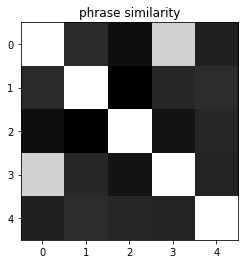

In [10]:
dummy_lines = [
    "How old are you?",                                                 # 0
    "In what mythology do two canines watch over the Chinvat Bridge?",  # 1
    "I'm sorry, okay, I'm not perfect, but I'm trying.",                # 2
    "What is your age?",                                                # 3
    "Beware, for I am fearless, and therefore powerful.",               # 4
]

dummy_vectors_np = universal_sentence_encoder(dummy_lines)["outputs"].numpy()

plt.title('phrase similarity')
plt.imshow(dummy_vectors_np.dot(dummy_vectors_np.T), interpolation='none', cmap='gray')

As you can see, __the strongest similarity is between lines 0 and 3__. Indeed they correspond to "How old are you?" and "What is your age?"

### Model (2 points)

Our goal for today is to build a model that measures similarity between question and answer. In particular, it maps both question and answer into fixed-size vectors such that:

Our model is a pair of $V_q(q)$ and $V_a(a)$ - networks that turn phrases into vectors. 

__Objective:__ Question vector $V_q(q)$ should be __closer__ to correct answer vectors $V_a(a^+)$ than to incorrect ones $V_a(a^-)$ .

Both vectorizers can be anything you wish. For starters, let's use a couple of dense layers on top of the Universal Sentence Encoder.




In [11]:
import tensorflow.keras.layers as L
import tensorflow.keras as keras

class Vectorizer(keras.Model):
    def __init__(self, output_size=256, hid_size=256, universal_sentence_encoder=universal_sentence_encoder):
        """ A small feedforward network on top of universal sentence encoder. 2-3 layers should be enough """
        super(Vectorizer, self).__init__()
        self.universal_sentence_encoder = universal_sentence_encoder
        
        # define a few layers to be applied on top of u.s.e.
        # note: please make sure your final layer comes with _linear_ activation
        self.first = L.Dense(256)
        

    def __call__(self, input_phrases, is_train=True):
        """
        Apply vectorizer. Use dropout and any other hacks at will.
        :param input_phrases: [batch_size] of tf.string
        :param is_train: if True, apply dropouts and other ops in train mode, 
                         if False - evaluation mode
        :returns: predicted phrase vectors, [batch_size, output_size]
        """
        return self.first(self.universal_sentence_encoder(input_phrases)['outputs'])

In [12]:
question_vectorizer = Vectorizer()
answer_vectorizer = Vectorizer()

In [18]:
# dummy_v_q = question_vectorizer(dummy_ph, is_train=True)
# dummy_v_q_det = question_vectorizer(dummy_ph, is_train=False)
# utils.initialize_uninitialized()
# assert sess.run(dummy_v_q, {dummy_ph: dummy_lines}).shape == (5, 256)
assert question_vectorizer(dummy_lines).shape == (5, 256)
assert np.allclose(
    question_vectorizer(dummy_lines, is_train=False).numpy(),
    question_vectorizer(dummy_lines, is_train=False).numpy(),
    atol=1e-7
), "make sure your model doesn't use dropout/noise or non-determinism if is_train=False"

print("Well done!")

Well done!


### Training: minibatches

Our model learns on triples $(q, a^+, a^-)$: 
* q - __q__uestion
* (a+) - correct __a__nswer
* (a-) - wrong __a__nswer 

Below you will find a generator that samples such triples from data.

In [20]:
import random

def iterate_minibatches(data, batch_size, shuffle=True, cycle=False):
    """
    Generates minibatches of triples: {questions, correct answers, wrong answers}
    If there are several wrong (or correct) answers, picks one at random.
    """
    indices = np.arange(len(data))
    while True:
        if shuffle:
            indices = np.random.permutation(indices)
        for batch_start in range(0, len(indices), batch_size):
            batch_indices = indices[batch_start: batch_start + batch_size]
            batch = data.iloc[batch_indices]
            questions = batch['question'].values
            correct_answers = np.array([
                row['options'][random.choice(row['correct_indices'])]
                for i, row in batch.iterrows()
            ])
            wrong_answers = np.array([
                row['options'][random.choice(row['wrong_indices'])]
                for i, row in batch.iterrows()
            ])

            yield {
                'questions' : questions,
                'correct_answers': correct_answers,
                'wrong_answers': wrong_answers,
            }
        if not cycle:
            break

In [21]:
dummy_batch = next(iterate_minibatches(train.sample(3), 3))
print(dummy_batch)

{'questions': array(['Not held back by size limits, webcomics are said to have a what?',
       'Which artist presented the Global Icon Award to Queen in 2011?',
       'How many locations can one use videoconferencing for?'],
      dtype=object), 'correct_answers': array(['Webcomics can make use of an infinite canvas—meaning they are not constrained by size or dimensions of a page.',
       'At the 2011 MTV Europe Music Awards on 6 November, Queen received the Global Icon Award, which Katy Perry presented to Brian May.',
       'A videoconference (also known as a videoteleconference) allows two or more locations to communicate via live, simultaneous two-way video and audio transmissions.'],
      dtype='<U161'), 'wrong_answers': array(['They are able to reach large audiences, and new readers usually can access archived installments.',
       'Farrell stated: "I have to keep Chris away from Queen, who want him and they\'re not gonna get him unless we\'re not doing anything.',
       'T

### Training: loss function (2 points)
We want our vectorizers to put correct answers closer to question vectors and incorrect answers farther away from them. One way to express this is to use is Pairwise Hinge Loss _(aka Triplet Loss)_. 

$$ L = \frac 1N \underset {q, a^+, a^-} \sum max(0, \space \delta - sim[V_q(q), V_a(a^+)] + sim[V_q(q), V_a(a^-)] )$$

, where
* sim[a, b] is some similarity function: dot product, cosine or negative distance
* δ - loss hyperparameter, e.g. δ=1.0. If sim[a, b] is linear in b, all δ > 0 are equivalent.


This reads as __Correct answers must be closer than the wrong ones by at least δ.__

![img](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/margin.png)
<center>_image: question vector is green, correct answers are blue, incorrect answers are red_</center>


Note: in effect, we train a Deep Semantic Similarity Model [DSSM](https://www.microsoft.com/en-us/research/project/dssm/). 

In [22]:
def similarity(a, b):
    """ Dot product as a similarity function """
    return tf.einsum("ij,ij->i", a, b)

def compute_loss(question_vectors, correct_answer_vectors, wrong_answer_vectors, delta=1.0):
    """ 
    Compute the triplet loss as per formula above.
    Use similarity function above for  sim[a, b]
    :param question_vectors: float32[batch_size, vector_size]
    :param correct_answer_vectors: float32[batch_size, vector_size]
    :param wrong_answer_vectors: float32[batch_size, vector_size]
    :returns: loss for every row in batch, float32[batch_size]
    Hint: DO NOT use tf.reduce_max, it's a wrong kind of maximum :)
    """
    pos = similarity(question_vectors, correct_answer_vectors)
    neg = similarity(question_vectors, wrong_answer_vectors)
    return tf.math.maximum(0, delta - pos + neg)

In [23]:
dummy_v1 = tf.constant([[0.1, 0.2, -1], [-1.2, 0.6, 1.0]], dtype=tf.float32)
dummy_v2 = tf.constant([[0.9, 2.1, -6.6], [0.1, 0.8, -2.2]], dtype=tf.float32)
dummy_v3 = tf.constant([[-4.1, 0.1, 1.2], [0.3, -1, -2]], dtype=tf.float32)

assert np.allclose(similarity(dummy_v1, dummy_v2).numpy(), [7.11, -1.84])
assert np.allclose(compute_loss(dummy_v1, dummy_v2, dummy_v3, delta=5.0).numpy(), [0.0, 3.88])

Once loss is working, let's train our model by our usual means.

In [24]:
opt = keras.optimizers.Adam(1e-3)

### Training loop

Just as we always do, we can now train DSSM on minibatches and periodically measure recall on validation data.


__Note 1:__ DSSM training may be very sensitive to the choice of batch size. Small batch size may decrease model quality.

__Note 2:__ here we use the same dataset as __"test set"__ and __"validation (dev) set"__. 

In any serious scientific experiment, those must be two separate sets. Validation is for hyperparameter tuning and testr is for final eval only.


In [31]:
import pandas as pd
from IPython.display import clear_output
from tqdm import tqdm

ewma = lambda x, span: pd.DataFrame({'x': x})['x'].ewm(span=span).mean().values
dev_batches = iterate_minibatches(test, batch_size=256, cycle=True)
loss_history = []
dev_recall_history = []

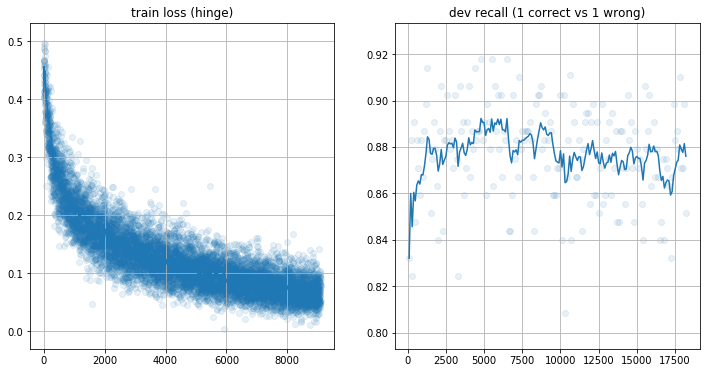

KeyboardInterrupt: 

In [32]:
# infinite training loop. Stop it manually or implement early stopping
for batch in iterate_minibatches(train, batch_size=256, cycle=True):
    with tf.GradientTape() as tape:
        v_q = question_vectorizer(batch['questions'])
        v_a_correct = answer_vectorizer(batch['correct_answers'])
        v_a_wrong = answer_vectorizer(batch['wrong_answers'])
        loss = tf.math.reduce_mean(compute_loss(v_q, v_a_correct, v_a_wrong))
    loss_history.append(loss.numpy())
    variables = question_vectorizer.trainable_variables + answer_vectorizer.trainable_variables
    grads = tape.gradient(loss, variables)
    opt.apply_gradients(zip(grads, variables))

    if len(loss_history) % 50 == 0:
        # measure dev recall = P(correct_is_closer_than_wrong | q, a+, a-)
        dev_batch = next(dev_batches)
        test_v_q = question_vectorizer(dev_batch['questions'])
        test_v_a_correct = answer_vectorizer(dev_batch['correct_answers'])
        test_v_a_wrong = answer_vectorizer(dev_batch['wrong_answers'])
        correct_is_closer = tf.greater(similarity(test_v_q, test_v_a_correct),
                                       similarity(test_v_q, test_v_a_wrong))
        recall_t = tf.reduce_mean(tf.cast(correct_is_closer, dtype=tf.float32)).numpy()
        dev_recall_history.append(recall_t)

    if len(loss_history) % 50 == 0:
        clear_output(True)
        plt.figure(figsize=[12, 6])
        plt.subplot(1, 2, 1), plt.title('train loss (hinge)'), plt.grid()
        plt.scatter(np.arange(len(loss_history)), loss_history, alpha=0.1)
        plt.plot(ewma(loss_history, span=100))
        plt.subplot(1, 2, 2), plt.title('dev recall (1 correct vs 1 wrong)'), plt.grid()
        dev_time = np.arange(1, len(dev_recall_history) + 1) * 100
        plt.scatter(dev_time, dev_recall_history, alpha=0.1)
        plt.plot(dev_time, ewma(dev_recall_history, span=10))
        plt.show()
    

In [33]:
print("Mean recall:", np.mean(dev_recall_history[-10:]))
assert np.mean(dev_recall_history[-10:]) > 0.85, "Please train for at least 85% recall on test set. "\
                                                  "You may need to change vectorizer model for that."
print("Well done!")

Mean recall: 0.8816406
Well done!


# Final evaluation (1 point)

Let's see how well does our model perform on actual question answering. 

Given a question and a set of possible answers, pick answer with highest similarity to estimate accuracy.

In [252]:
# optional: build tf graph required for select_best_answer
# <...>

def select_best_answer(question, possible_answers):
    """
    Predicts which answer best fits the question
    :param question: a single string containing a question
    :param possible_answers: a list of strings containing possible answers
    :returns: integer - the index of best answer in possible_answer
    """
    question_vec = question_vectorizer([question], is_train=False)
    answers_vec = answer_vectorizer(possible_answers, is_train=False)
    scores = tf.matmul(question_vec, tf.transpose(answers_vec))
    return tf.math.argmax(tf.reshape(scores, [-1])).numpy()
    

In [68]:
predicted_answers = [
    select_best_answer(question, possible_answers)
    for i, (question, possible_answers) in test[['question', 'options']].iterrows()
]

accuracy = np.mean([
    answer in correct_ix
    for answer, correct_ix in zip(predicted_answers, test['correct_indices'].values)
])
print("Accuracy: %0.5f" % accuracy)
assert accuracy > 0.65, "we need more accuracy!"
print("Great job!")

Accuracy: 0.71524
Great job!


In [69]:
def draw_results(question, possible_answers, predicted_index, correct_indices):
    print("Q:", question, end='\n\n')
    for i, answer in enumerate(possible_answers):
        print("#%i: %s %s" % (i, '[*]' if i == predicted_index else '[ ]', answer))
    
    print("\nVerdict:", "CORRECT" if predicted_index in correct_indices else "INCORRECT", 
          "(ref: %s)" % correct_indices, end='\n' * 3)

In [70]:
for i in [1, 100, 1000, 2000, 3000, 4000, 5000]:
    draw_results(test.iloc[i].question, test.iloc[i].options,
                 predicted_answers[i], test.iloc[i].correct_indices)

Q: Which three countries did Beyonce's song "Work It Out" achieve top ten status?

#0: [ ] In July 2002, Beyoncé continued her acting career playing Foxxy Cleopatra alongside Mike Myers in the comedy film, Austin Powers in Goldmember, which spent its first weekend atop the US box office and grossed $73 million.
#1: [*] Beyoncé released "Work It Out" as the lead single from its soundtrack album which entered the top ten in the UK, Norway, and Belgium.
#2: [ ] In 2003, Beyoncé starred opposite Cuba Gooding, Jr., in the musical comedy The Fighting Temptations as Lilly, a single mother whom Gooding's character falls in love with.
#3: [ ] The film received mixed reviews from critics but grossed $30 million in the U.S. Beyoncé released "Fighting Temptation" as the lead single from the film's soundtrack album, with Missy Elliott, MC Lyte, and Free which was also used to promote the film.
#4: [ ] Another of Beyoncé's contributions to the soundtrack, "Summertime", fared better on the US charts.

In [83]:
question = "Why is Putin thief?" # your question here!
possible_answers1 = [
    "Because",
    "It is lie",
    "Because Medvedev's vicious influence"
]
possible_answers2 = [
    "Because",
    "It is lie",
    "Medvedev's vicious influence"
]
predicted_answer1 = select_best_answer(question, possible_answers1)
predicted_answer2 = select_best_answer(question, possible_answers2)
draw_results(question, possible_answers1,
             predicted_answer1, [0])
draw_results(question, possible_answers2,
             predicted_answer2, [0])

Q: Why is Putin thief?

#0: [ ] Because
#1: [ ] It is lie
#2: [*] Because Medvedev's vicious influence

Verdict: INCORRECT (ref: [0])


Q: Why is Putin thief?

#0: [*] Because
#1: [ ] It is lie
#2: [ ] Medvedev's vicious influence

Verdict: CORRECT (ref: [0])




### Bonus tasks

There are many ways to improve our question answering model. Here's a bunch of things you can do to increase your understanding and get bonus points.

At first add early stopping conditionand evaluate default model again

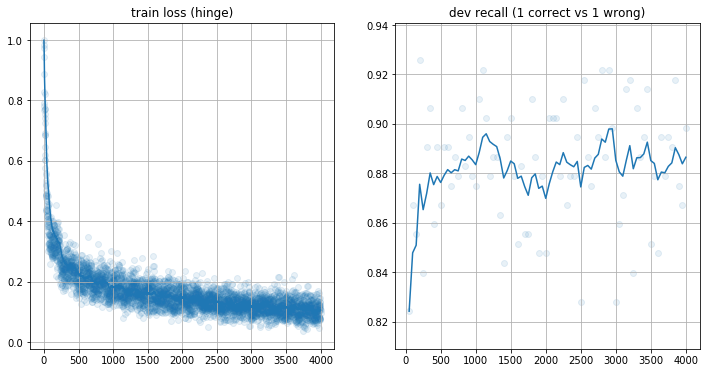

In [86]:
# infinite training loop. Stop it manually or implement early stopping
ewma = lambda x, span: pd.DataFrame({'x': x})['x'].ewm(span=span).mean().values
dev_batches = iterate_minibatches(test, batch_size=256, cycle=True)
loss_history = []
dev_recall_history = []
question_vectorizer = Vectorizer()
answer_vectorizer = Vectorizer()

for batch in iterate_minibatches(train, batch_size=256, cycle=True):
    with tf.GradientTape() as tape:
        v_q = question_vectorizer(batch['questions'])
        v_a_correct = answer_vectorizer(batch['correct_answers'])
        v_a_wrong = answer_vectorizer(batch['wrong_answers'])
        loss = tf.math.reduce_mean(compute_loss(v_q, v_a_correct, v_a_wrong))
    loss_history.append(loss.numpy())
    variables = question_vectorizer.trainable_variables + answer_vectorizer.trainable_variables
    grads = tape.gradient(loss, variables)
    opt.apply_gradients(zip(grads, variables))

    if len(loss_history) % 50 == 0:
        # measure dev recall = P(correct_is_closer_than_wrong | q, a+, a-)
        dev_batch = next(dev_batches)
        test_v_q = question_vectorizer(dev_batch['questions'])
        test_v_a_correct = answer_vectorizer(dev_batch['correct_answers'])
        test_v_a_wrong = answer_vectorizer(dev_batch['wrong_answers'])
        correct_is_closer = tf.greater(similarity(test_v_q, test_v_a_correct),
                                       similarity(test_v_q, test_v_a_wrong))
        recall_t = tf.reduce_mean(tf.cast(correct_is_closer, dtype=tf.float32)).numpy()
        dev_recall_history.append(recall_t)

    if len(loss_history) % 50 == 0:
        clear_output(True)
        plt.figure(figsize=[12, 6])
        plt.subplot(1, 2, 1), plt.title('train loss (hinge)'), plt.grid()
        plt.scatter(np.arange(len(loss_history)), loss_history, alpha=0.1)
        plt.plot(ewma(loss_history, span=100))
        plt.subplot(1, 2, 2), plt.title('dev recall (1 correct vs 1 wrong)'), plt.grid()
        dev_time = np.arange(1, len(dev_recall_history) + 1) * 50
        plt.scatter(dev_time, dev_recall_history, alpha=0.1)
        plt.plot(dev_time, ewma(dev_recall_history, span=10))
        plt.show()
    
    if len(loss_history) == 4000:
        break

In [87]:
predicted_answers = [
    select_best_answer(question, possible_answers)
    for i, (question, possible_answers) in test[['question', 'options']].iterrows()
]

accuracy = np.mean([
    answer in correct_ix
    for answer, correct_ix in zip(predicted_answers, test['correct_indices'].values)
])
print("Accuracy: %0.5f" % accuracy)
assert accuracy > 0.65, "we need more accuracy!"
print("Great job!")

Accuracy: 0.72992
Great job!


### 1.  Hard Negatives (3+ pts)

Not all wrong answers are equally wrong. As the training progresses, _most negative examples $a^-$ will be to easy._ So easy in fact, that loss function and gradients on such negatives is exactly __0.0__. To improve training efficiency, one can __mine hard negative samples__.

Given a list of answers,
* __Hard negative__ is the wrong answer with highest similarity with question,

$$a^-_{hard} = \underset {a^-} {argmax} \space sim[V_q(q), V_a(a^-)]$$

* __Semi-hard negative__ is the one with highest similarity _among wrong answers that are farther than positive one. This option is more useful if some wrong answers may actually be mislabelled correct answers.

* One can also __sample__ negatives proportionally to $$P(a^-_i) \sim e ^ {sim[V_q(q), V_a(a^-_i)]}$$


The task is to implement at least __hard negative__ sampling and apply it for model training.





#### 1.1 Try hard negatives in batch

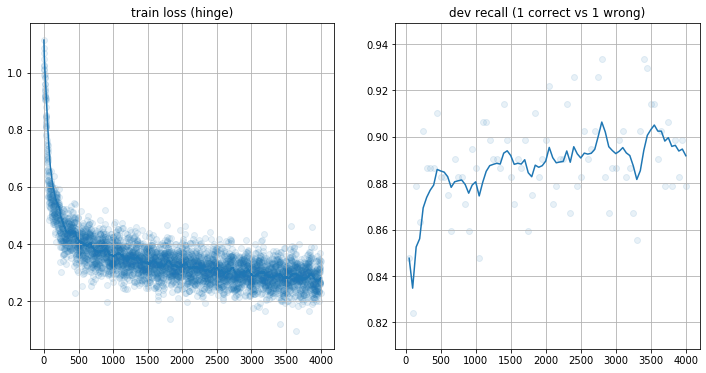

Accuracy: 0.76337
Great job!


In [125]:
# infinite training loop. Stop it manually or implement early stopping
BATCH_SIZE = 256
ewma = lambda x, span: pd.DataFrame({'x': x})['x'].ewm(span=span).mean().values
dev_batches = iterate_minibatches(test, batch_size=BATCH_SIZE, cycle=True)
loss_history = []
dev_recall_history = []
question_vectorizer = Vectorizer()
answer_vectorizer = Vectorizer()

for batch in iterate_minibatches(train, batch_size=BATCH_SIZE, cycle=True):
    with tf.GradientTape() as tape:
        v_q = question_vectorizer(batch['questions'])
        v_a_correct = answer_vectorizer(batch['correct_answers'])
        v_a_wrong = answer_vectorizer(batch['wrong_answers'])
        all_scores = tf.einsum('ab,cb->ac', v_q, v_a_wrong)
        hard_wrong = tf.matmul(tf.one_hot(tf.argmax(all_scores, axis=1), v_q.shape[0]), v_a_wrong)
        loss = tf.math.reduce_mean(compute_loss(v_q, v_a_correct, hard_wrong))
    loss_history.append(loss.numpy())
    variables = question_vectorizer.trainable_variables + answer_vectorizer.trainable_variables
    grads = tape.gradient(loss, variables)
    opt.apply_gradients(zip(grads, variables))

    if len(loss_history) % 50 == 0:
        # measure dev recall = P(correct_is_closer_than_wrong | q, a+, a-)
        dev_batch = next(dev_batches)
        test_v_q = question_vectorizer(dev_batch['questions'])
        test_v_a_correct = answer_vectorizer(dev_batch['correct_answers'])
        test_v_a_wrong = answer_vectorizer(dev_batch['wrong_answers'])
        correct_is_closer = tf.greater(similarity(test_v_q, test_v_a_correct),
                                       similarity(test_v_q, test_v_a_wrong))
        recall_t = tf.reduce_mean(tf.cast(correct_is_closer, dtype=tf.float32)).numpy()
        dev_recall_history.append(recall_t)

    if len(loss_history) % 50 == 0:
        clear_output(True)
        plt.figure(figsize=[12, 6])
        plt.subplot(1, 2, 1), plt.title('train loss (hinge)'), plt.grid()
        plt.scatter(np.arange(len(loss_history)), loss_history, alpha=0.1)
        plt.plot(ewma(loss_history, span=100))
        plt.subplot(1, 2, 2), plt.title('dev recall (1 correct vs 1 wrong)'), plt.grid()
        dev_time = np.arange(1, len(dev_recall_history) + 1) * 50
        plt.scatter(dev_time, dev_recall_history, alpha=0.1)
        plt.plot(dev_time, ewma(dev_recall_history, span=10))
        plt.show()
    
    if len(loss_history) == 4000:
        break
        
predicted_answers = [
    select_best_answer(question, possible_answers)
    for i, (question, possible_answers) in test[['question', 'options']].iterrows()
]

accuracy = np.mean([
    answer in correct_ix
    for answer, correct_ix in zip(predicted_answers, test['correct_indices'].values)
])
print("Accuracy: %0.5f" % accuracy)
assert accuracy > 0.65, "we need more accuracy!"
print("Great job!")

#### Try semi-hard negatives

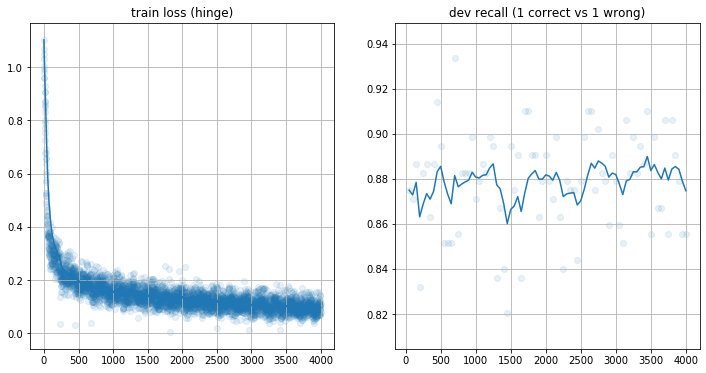

Accuracy: 0.74865
Great job!


In [137]:
# infinite training loop. Stop it manually or implement early stopping
BATCH_SIZE = 256
ewma = lambda x, span: pd.DataFrame({'x': x})['x'].ewm(span=span).mean().values
dev_batches = iterate_minibatches(test, batch_size=BATCH_SIZE, cycle=True)
loss_history = []
dev_recall_history = []
question_vectorizer = Vectorizer()
answer_vectorizer = Vectorizer()

for batch in iterate_minibatches(train, batch_size=BATCH_SIZE, cycle=True):
    with tf.GradientTape() as tape:
        v_q = question_vectorizer(batch['questions'])
        v_a_correct = answer_vectorizer(batch['correct_answers'])
        v_a_wrong = answer_vectorizer(batch['wrong_answers'])
        all_scores = tf.einsum('ab,cb->ac', v_q, v_a_wrong)
        hard_wrong = tf.matmul(tf.one_hot(tf.math.top_k(all_scores, k=2)[1][:, 1], v_q.shape[0]), v_a_wrong)
        loss = tf.math.reduce_mean(compute_loss(v_q, v_a_correct, hard_wrong))
    loss_history.append(loss.numpy())
    variables = question_vectorizer.trainable_variables + answer_vectorizer.trainable_variables
    grads = tape.gradient(loss, variables)
    opt.apply_gradients(zip(grads, variables))

    if len(loss_history) % 50 == 0:
        # measure dev recall = P(correct_is_closer_than_wrong | q, a+, a-)
        dev_batch = next(dev_batches)
        test_v_q = question_vectorizer(dev_batch['questions'])
        test_v_a_correct = answer_vectorizer(dev_batch['correct_answers'])
        test_v_a_wrong = answer_vectorizer(dev_batch['wrong_answers'])
        correct_is_closer = tf.greater(similarity(test_v_q, test_v_a_correct),
                                       similarity(test_v_q, test_v_a_wrong))
        recall_t = tf.reduce_mean(tf.cast(correct_is_closer, dtype=tf.float32)).numpy()
        dev_recall_history.append(recall_t)

    if len(loss_history) % 50 == 0:
        clear_output(True)
        plt.figure(figsize=[12, 6])
        plt.subplot(1, 2, 1), plt.title('train loss (hinge)'), plt.grid()
        plt.scatter(np.arange(len(loss_history)), loss_history, alpha=0.1)
        plt.plot(ewma(loss_history, span=100))
        plt.subplot(1, 2, 2), plt.title('dev recall (1 correct vs 1 wrong)'), plt.grid()
        dev_time = np.arange(1, len(dev_recall_history) + 1) * 50
        plt.scatter(dev_time, dev_recall_history, alpha=0.1)
        plt.plot(dev_time, ewma(dev_recall_history, span=10))
        plt.show()
    
    if len(loss_history) == 4000:
        break
        
predicted_answers = [
    select_best_answer(question, possible_answers)
    for i, (question, possible_answers) in test[['question', 'options']].iterrows()
]

accuracy = np.mean([
    answer in correct_ix
    for answer, correct_ix in zip(predicted_answers, test['correct_indices'].values)
])
print("Accuracy: %0.5f" % accuracy)
assert accuracy > 0.65, "we need more accuracy!"
print("Great job!")

### 2. Bring Your Own Model (3+ pts)
In addition to Universal Sentence Encoder, one can also train a new model.
* You name it: convolutions, RNN, self-attention
* Use pre-trained ELMO or FastText embeddings
* Monitor overfitting and use dropout / word dropout to improve performance

__Note:__ if you use ELMO please note that it requires tokenized text while USE can deal with raw strings. You can tokenize data manually or use tokenized=True when reading dataset.


* hard negatives (strategies: hardest, hardest farter than current, randomized)
* train model on the full dataset to see if it can mine answers to new questions over the entire wikipedia. Use approximate nearest neighbor search for fast lookup.

In [174]:
import io

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = list(map(float, tokens[1:]))
    return data

In [175]:
fast_text = load_vectors('wiki-news-300d-1M.vec')

In [243]:
class Vectorizer2_0(keras.Model):
    def __init__(self, output_size=256, hid_size=256, universal_sentence_encoder=universal_sentence_encoder):
        """ A small feedforward network on top of universal sentence encoder. 2-3 layers should be enough """
        super(Vectorizer2_0, self).__init__()
        self.universal_sentence_encoder = universal_sentence_encoder
        self.emb_size = 300
        self.out_size = output_size
        
        # define a few layers to be applied on top of u.s.e.
        # note: please make sure your final layer comes with _linear_ activation
        self.first = L.Dense(self.out_size)
        self.gru = L.GRU(self.out_size)
        self.bos = self.add_variable("bos", shape=[self.emb_size])
        self.eos = self.add_variable("eos", shape=[self.emb_size])
        self.unk = self.add_variable("unk", shape=[self.emb_size])
        
    def tokenize(self, phrase):
        tokens = [fast_text[tok] if tok in fast_text else self.unk
                  for tok in phrase.split()]
        return [self.bos] + tokens + [self.eos]

    def __call__(self, input_phrases, is_train=True):
        """
        Apply vectorizer. Use dropout and any other hacks at will.
        :param input_phrases: [batch_size] of tf.string
        :param is_train: if True, apply dropouts and other ops in train mode, 
                         if False - evaluation mode
        :returns: predicted phrase vectors, [batch_size, output_size]
        """
        batch_size = len(input_phrases)
        splitted_phrases = list(map(self.tokenize, input_phrases))
        lens = np.array(list(map(len, splitted_phrases)))
        max_len = max(lens)
        batch = tf.concat(
            [[tf.concat([phrase + [self.eos] * (max_len - len(phrase))], axis=0)] for phrase in splitted_phrases],
            axis=0
        )
        mask = tf.convert_to_tensor(
            [[True] * len(phrase) + [False] * (max_len - len(phrase)) for phrase in splitted_phrases]
        )
        assert batch.shape == (batch_size, max_len, self.emb_size), batch.shape
        gru_result = self.gru(inputs=batch, mask=mask)
        assert gru_result.shape == (batch_size, self.out_size), gru_result.shape
        use_output = self.first(self.universal_sentence_encoder(input_phrases)['outputs'])
        result = tf.concat([gru_result, use_output], axis=1)
        assert result.shape == (batch_size, self.out_size * 2)
        return result

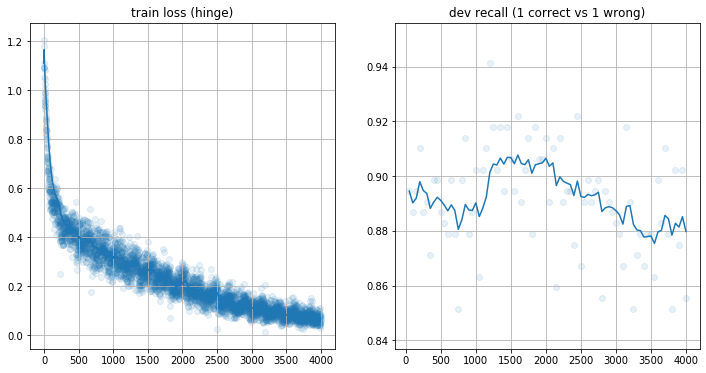

Accuracy: 0.75273
Great job!


In [244]:
# infinite training loop. Stop it manually or implement early stopping
BATCH_SIZE = 256
ewma = lambda x, span: pd.DataFrame({'x': x})['x'].ewm(span=span).mean().values
dev_batches = iterate_minibatches(test, batch_size=BATCH_SIZE, cycle=True)
loss_history = []
dev_recall_history = []
question_vectorizer = Vectorizer2_0()
answer_vectorizer = Vectorizer2_0()

for batch in iterate_minibatches(train, batch_size=BATCH_SIZE, cycle=True):
    with tf.GradientTape() as tape:
        v_q = question_vectorizer(batch['questions'])
        v_a_correct = answer_vectorizer(batch['correct_answers'])
        v_a_wrong = answer_vectorizer(batch['wrong_answers'])
        all_scores = tf.einsum('ab,cb->ac', v_q, v_a_wrong)
        hard_wrong = tf.gather(v_a_wrong, tf.argmax(all_scores, axis=1).numpy(), axis=0)
        loss = tf.math.reduce_mean(compute_loss(v_q, v_a_correct, hard_wrong))
    loss_history.append(loss.numpy())
    variables = question_vectorizer.trainable_variables + answer_vectorizer.trainable_variables
    grads = tape.gradient(loss, variables)
    opt.apply_gradients(zip(grads, variables))

    if len(loss_history) % 50 == 0:
        # measure dev recall = P(correct_is_closer_than_wrong | q, a+, a-)
        dev_batch = next(dev_batches)
        test_v_q = question_vectorizer(dev_batch['questions'])
        test_v_a_correct = answer_vectorizer(dev_batch['correct_answers'])
        test_v_a_wrong = answer_vectorizer(dev_batch['wrong_answers'])
        correct_is_closer = tf.greater(similarity(test_v_q, test_v_a_correct),
                                       similarity(test_v_q, test_v_a_wrong))
        recall_t = tf.reduce_mean(tf.cast(correct_is_closer, dtype=tf.float32)).numpy()
        dev_recall_history.append(recall_t)

    if len(loss_history) % 50 == 0:
        clear_output(True)
        plt.figure(figsize=[12, 6])
        plt.subplot(1, 2, 1), plt.title('train loss (hinge)'), plt.grid()
        plt.scatter(np.arange(len(loss_history)), loss_history, alpha=0.1)
        plt.plot(ewma(loss_history, span=100))
        plt.subplot(1, 2, 2), plt.title('dev recall (1 correct vs 1 wrong)'), plt.grid()
        dev_time = np.arange(1, len(dev_recall_history) + 1) * 50
        plt.scatter(dev_time, dev_recall_history, alpha=0.1)
        plt.plot(dev_time, ewma(dev_recall_history, span=10))
        plt.show()
    
    if len(loss_history) == 4000:
        break
        
predicted_answers = [
    select_best_answer(question, possible_answers)
    for i, (question, possible_answers) in test[['question', 'options']].iterrows()
]

accuracy = np.mean([
    answer in correct_ix
    for answer, correct_ix in zip(predicted_answers, test['correct_indices'].values)
])
print("Accuracy: %0.5f" % accuracy)
assert accuracy > 0.65, "we need more accuracy!"
print("Great job!")

Seems, that model overfeet. Try add word_dropout.

In [253]:
class Vectorizer2_0(keras.Model):
    def __init__(self, output_size=256, hid_size=256, universal_sentence_encoder=universal_sentence_encoder,
                 word_dropout=0.0):
        """ A small feedforward network on top of universal sentence encoder. 2-3 layers should be enough """
        super(Vectorizer2_0, self).__init__()
        self.universal_sentence_encoder = universal_sentence_encoder
        self.emb_size = 300
        self.out_size = output_size
        self.word_dropout = word_dropout
        
        # define a few layers to be applied on top of u.s.e.
        # note: please make sure your final layer comes with _linear_ activation
        self.first = L.Dense(self.out_size)
        self.gru = L.GRU(self.out_size)
        self.bos = self.add_variable("bos", shape=[self.emb_size])
        self.eos = self.add_variable("eos", shape=[self.emb_size])
        self.unk = self.add_variable("unk", shape=[self.emb_size])
        
    def tokenize(self, phrases, is_train):
        dropout = self.word_dropout if is_train else 0.0
        tokens = list(map(lambda phrase: 
            [fast_text[tok] if tok in fast_text and np.random.rand(1) > dropout else self.unk
            for tok in phrase.split()],
            phrases
        ))
        return list(map(lambda toks: [self.bos] + toks + [self.eos], tokens))

    def __call__(self, input_phrases, is_train=True):
        """
        Apply vectorizer. Use dropout and any other hacks at will.
        :param input_phrases: [batch_size] of tf.string
        :param is_train: if True, apply dropouts and other ops in train mode, 
                         if False - evaluation mode
        :returns: predicted phrase vectors, [batch_size, output_size]
        """
        batch_size = len(input_phrases)
        splitted_phrases = self.tokenize(input_phrases, is_train)
        lens = np.array(list(map(len, splitted_phrases)))
        max_len = max(lens)
        batch = tf.concat(
            [[tf.concat([phrase + [self.eos] * (max_len - len(phrase))], axis=0)] for phrase in splitted_phrases],
            axis=0
        )
        mask = tf.convert_to_tensor(
            [[True] * len(phrase) + [False] * (max_len - len(phrase)) for phrase in splitted_phrases]
        )
        assert batch.shape == (batch_size, max_len, self.emb_size), batch.shape
        gru_result = self.gru(inputs=batch, mask=mask)
        assert gru_result.shape == (batch_size, self.out_size), gru_result.shape
        use_output = self.first(self.universal_sentence_encoder(input_phrases)['outputs'])
        result = tf.concat([gru_result, use_output], axis=1)
        assert result.shape == (batch_size, self.out_size * 2)
        return result

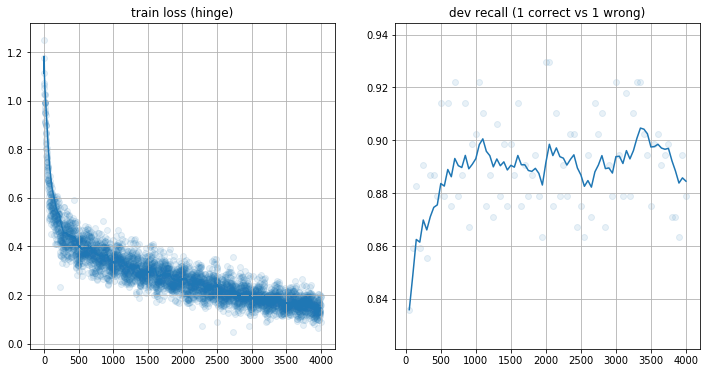

In [ ]:
# infinite training loop. Stop it manually or implement early stopping
BATCH_SIZE = 256
ewma = lambda x, span: pd.DataFrame({'x': x})['x'].ewm(span=span).mean().values
dev_batches = iterate_minibatches(test, batch_size=BATCH_SIZE, cycle=True)
loss_history = []
dev_recall_history = []
question_vectorizer = Vectorizer2_0(word_dropout=0.15)
answer_vectorizer = Vectorizer2_0(word_dropout=0.15)

for batch in iterate_minibatches(train, batch_size=BATCH_SIZE, cycle=True):
    with tf.GradientTape() as tape:
        v_q = question_vectorizer(batch['questions'])
        v_a_correct = answer_vectorizer(batch['correct_answers'])
        v_a_wrong = answer_vectorizer(batch['wrong_answers'])
        all_scores = tf.einsum('ab,cb->ac', v_q, v_a_wrong)
        hard_wrong = tf.gather(v_a_wrong, tf.argmax(all_scores, axis=1).numpy(), axis=0)
        loss = tf.math.reduce_mean(compute_loss(v_q, v_a_correct, hard_wrong))
    loss_history.append(loss.numpy())
    variables = question_vectorizer.trainable_variables + answer_vectorizer.trainable_variables
    grads = tape.gradient(loss, variables)
    opt.apply_gradients(zip(grads, variables))

    if len(loss_history) % 50 == 0:
        # measure dev recall = P(correct_is_closer_than_wrong | q, a+, a-)
        dev_batch = next(dev_batches)
        test_v_q = question_vectorizer(dev_batch['questions'], is_train=False)
        test_v_a_correct = answer_vectorizer(dev_batch['correct_answers'], is_train=False)
        test_v_a_wrong = answer_vectorizer(dev_batch['wrong_answers'], is_train=False)
        correct_is_closer = tf.greater(similarity(test_v_q, test_v_a_correct),
                                       similarity(test_v_q, test_v_a_wrong))
        recall_t = tf.reduce_mean(tf.cast(correct_is_closer, dtype=tf.float32)).numpy()
        dev_recall_history.append(recall_t)

    if len(loss_history) % 50 == 0:
        clear_output(True)
        plt.figure(figsize=[12, 6])
        plt.subplot(1, 2, 1), plt.title('train loss (hinge)'), plt.grid()
        plt.scatter(np.arange(len(loss_history)), loss_history, alpha=0.1)
        plt.plot(ewma(loss_history, span=100))
        plt.subplot(1, 2, 2), plt.title('dev recall (1 correct vs 1 wrong)'), plt.grid()
        dev_time = np.arange(1, len(dev_recall_history) + 1) * 50
        plt.scatter(dev_time, dev_recall_history, alpha=0.1)
        plt.plot(dev_time, ewma(dev_recall_history, span=10))
        plt.show()
    
    if len(loss_history) == 4000:
        break
        
predicted_answers = [
    select_best_answer(question, possible_answers)
    for i, (question, possible_answers) in test[['question', 'options']].iterrows()
]

accuracy = np.mean([
    answer in correct_ix
    for answer, correct_ix in zip(predicted_answers, test['correct_indices'].values)
])
print("Accuracy: %0.5f" % accuracy)
assert accuracy > 0.65, "we need more accuracy!"
print("Great job!")

In [257]:
print("Accuracy: %0.5f" % accuracy)
assert accuracy > 0.65, "we need more accuracy!"
print("Great job!")

Accuracy: 0.76433
Great job!


#### Try Bidirectional GRU

In [265]:
class Vectorizer2_0(keras.Model):
    def __init__(self, output_size=256, hid_size=256, universal_sentence_encoder=universal_sentence_encoder,
                 word_dropout=0.0):
        """ A small feedforward network on top of universal sentence encoder. 2-3 layers should be enough """
        super(Vectorizer2_0, self).__init__()
        self.universal_sentence_encoder = universal_sentence_encoder
        self.emb_size = 300
        self.out_size = output_size
        self.hid_size = hid_size
        self.word_dropout = word_dropout
        
        # define a few layers to be applied on top of u.s.e.
        # note: please make sure your final layer comes with _linear_ activation
        self.first = L.Dense(self.out_size)
        self.gru = L.Bidirectional(L.GRU(self.hid_size))
        self.second = L.Dense(self.out_size)
        self.bos = self.add_variable("bos", shape=[self.emb_size])
        self.eos = self.add_variable("eos", shape=[self.emb_size])
        self.unk = self.add_variable("unk", shape=[self.emb_size])
        
    def tokenize(self, phrases, is_train):
        dropout = self.word_dropout if is_train else 0.0
        tokens = list(map(lambda phrase: 
            [fast_text[tok] if tok in fast_text and np.random.rand(1) > dropout else self.unk
            for tok in phrase.split()],
            phrases
        ))
        return list(map(lambda toks: [self.bos] + toks + [self.eos], tokens))

    def __call__(self, input_phrases, is_train=True):
        """
        Apply vectorizer. Use dropout and any other hacks at will.
        :param input_phrases: [batch_size] of tf.string
        :param is_train: if True, apply dropouts and other ops in train mode, 
                         if False - evaluation mode
        :returns: predicted phrase vectors, [batch_size, output_size]
        """
        batch_size = len(input_phrases)
        splitted_phrases = self.tokenize(input_phrases, is_train)
        lens = np.array(list(map(len, splitted_phrases)))
        max_len = max(lens)
        batch = tf.concat(
            [[tf.concat([phrase + [self.eos] * (max_len - len(phrase))], axis=0)] for phrase in splitted_phrases],
            axis=0
        )
        mask = tf.convert_to_tensor(
            [[True] * len(phrase) + [False] * (max_len - len(phrase)) for phrase in splitted_phrases]
        )
        assert batch.shape == (batch_size, max_len, self.emb_size), batch.shape
        gru_result = self.second(self.gru(inputs=batch, mask=mask))
        assert gru_result.shape == (batch_size, self.out_size), gru_result.shape
        use_output = self.first(self.universal_sentence_encoder(input_phrases)['outputs'])
        result = tf.concat([gru_result, use_output], axis=1)
        assert result.shape == (batch_size, self.out_size * 2)
        return result

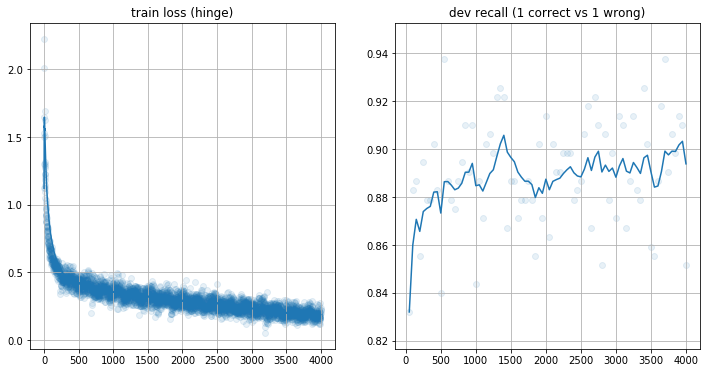

Accuracy: 0.76211
Great job!


In [266]:
# infinite training loop. Stop it manually or implement early stopping
BATCH_SIZE = 256
ewma = lambda x, span: pd.DataFrame({'x': x})['x'].ewm(span=span).mean().values
dev_batches = iterate_minibatches(test, batch_size=BATCH_SIZE, cycle=True)
loss_history = []
dev_recall_history = []
question_vectorizer = Vectorizer2_0(word_dropout=0.15)
answer_vectorizer = Vectorizer2_0(word_dropout=0.15)

for batch in iterate_minibatches(train, batch_size=BATCH_SIZE, cycle=True):
    with tf.GradientTape() as tape:
        v_q = question_vectorizer(batch['questions'])
        v_a_correct = answer_vectorizer(batch['correct_answers'])
        v_a_wrong = answer_vectorizer(batch['wrong_answers'])
        all_scores = tf.einsum('ab,cb->ac', v_q, v_a_wrong)
        hard_wrong = tf.gather(v_a_wrong, tf.argmax(all_scores, axis=1).numpy(), axis=0)
        loss = tf.math.reduce_mean(compute_loss(v_q, v_a_correct, hard_wrong))
    loss_history.append(loss.numpy())
    variables = question_vectorizer.trainable_variables + answer_vectorizer.trainable_variables
    grads = tape.gradient(loss, variables)
    opt.apply_gradients(zip(grads, variables))

    if len(loss_history) % 50 == 0:
        # measure dev recall = P(correct_is_closer_than_wrong | q, a+, a-)
        dev_batch = next(dev_batches)
        test_v_q = question_vectorizer(dev_batch['questions'], is_train=False)
        test_v_a_correct = answer_vectorizer(dev_batch['correct_answers'], is_train=False)
        test_v_a_wrong = answer_vectorizer(dev_batch['wrong_answers'], is_train=False)
        correct_is_closer = tf.greater(similarity(test_v_q, test_v_a_correct),
                                       similarity(test_v_q, test_v_a_wrong))
        recall_t = tf.reduce_mean(tf.cast(correct_is_closer, dtype=tf.float32)).numpy()
        dev_recall_history.append(recall_t)

    if len(loss_history) % 50 == 0:
        clear_output(True)
        plt.figure(figsize=[12, 6])
        plt.subplot(1, 2, 1), plt.title('train loss (hinge)'), plt.grid()
        plt.scatter(np.arange(len(loss_history)), loss_history, alpha=0.1)
        plt.plot(ewma(loss_history, span=100))
        plt.subplot(1, 2, 2), plt.title('dev recall (1 correct vs 1 wrong)'), plt.grid()
        dev_time = np.arange(1, len(dev_recall_history) + 1) * 50
        plt.scatter(dev_time, dev_recall_history, alpha=0.1)
        plt.plot(dev_time, ewma(dev_recall_history, span=10))
        plt.show()
    
    if len(loss_history) == 4000:
        break
        
predicted_answers = [
    select_best_answer(question, possible_answers)
    for i, (question, possible_answers) in test[['question', 'options']].iterrows()
]

accuracy = np.mean([
    answer in correct_ix
    for answer, correct_ix in zip(predicted_answers, test['correct_indices'].values)
])
print("Accuracy: %0.5f" % accuracy)
assert accuracy > 0.65, "we need more accuracy!"
print("Great job!")

### 3. Search engine (3+ pts)

Our basic model only selects answers from 2-5 available sentences in paragraph. You can extend it to search over __the whole dataset__. All sentences in all other paragraphs are viable answers.

The goal is to train such a model and use it to __quickly find top-10 answers from the whole set__.

* You can ask such model a question of your own making - to see which answers it can find among the entire training dataset or even the entire wikipedia.
* Searching for top-K neighbors is easier if you use specialized methods: [KD-Tree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html) or [HNSW](https://github.com/nmslib/hnswlib). 
* This task is much easier to train if you use hard or semi-hard negatives. You can even find hard negatives for one question from correct answers to other questions in batch - do so in-graph for maximum efficiency. See [1.] for more details.



In [281]:
from sklearn.neighbors import KDTree

In [356]:
questions = [
    question
    for i, (question, possible_answers) in test[['question', 'options']].iterrows()
]

answers = [
    answer
    for i, (question, possible_answers) in test[['question', 'options']].iterrows()
    for answer in possible_answers
]

answers = list(set(answers))

In [359]:
question_vectors = [
    question_vectorizer([question], is_train=False).numpy()
    for question in questions
]

answer_vectors = [
    answer_vectorizer([answer], is_train=False).numpy()
    for answer in answers
]

In [360]:
question_vectors = np.concatenate(question_vectors, axis=0)
answer_vectors = np.concatenate(answer_vectors, axis=0)

#### Try brute

In [368]:
for i in range(0, len(question_vectors), 5000):
    top10_ids = [0] * 10
    top10_results = [0] * 10
    for j, ans in enumerate(answer_vectors):
        res = np.sum(question_vectors[i] * ans)
        for k in range(10):
            if res > top10_results[k]:
                top10_results = top10_results[:k] + [res] + top10_results[k:10]
                top10_ids = top10_ids[:k] + [j] + top10_ids[k:10]
                break
    print(questions[i])
    for ans in top10_ids:
        print('\t' + answers[ans])
    print()

Who did Beyonce star with in the movie, "Austin Powers in Goldmember"?
	She recorded the single "Beautiful Stranger" for the 1999 film Austin Powers: The Spy Who Shagged Me.
	In July 2002, Beyoncé continued her acting career playing Foxxy Cleopatra alongside Mike Myers in the comedy film, Austin Powers in Goldmember, which spent its first weekend atop the US box office and grossed $73 million.
	In 2003, Beyoncé starred opposite Cuba Gooding, Jr., in the musical comedy The Fighting Temptations as Lilly, a single mother whom Gooding's character falls in love with.
	Beyoncé starred opposite Ali Larter and Idris Elba in the thriller, Obsessed.
	Thor Christensen of The Dallas Morning News commented that while Madonna earned a reputation for lip-syncing during her 1990 Blond Ambition World Tour, she has subsequently reorganized her performances by "stay[ing] mostly still during her toughest singing parts and [leaves] the dance routines to her backup troupe ... [r]ather than try to croon and 

When was the first Ottoman madrasa built?
	"The first Ottoman Medrese was created in İznik in 1331 and most Ottoman medreses followed the traditions of Sunni Islam."
	One hundred and ten scenes of mosaics in the atrium of St Mark's were based directly on the miniatures of the Cotton Genesis, a Byzantine manuscript that was brought to Venice after the sack of Constantinople (1204).
	The earliest dynasty, known as the "Badami Chalukyas", ruled from Vatapi (modern Badami) from the middle of the 6th century.
	The outer walls and circular piers are of 11th-century date, several of the capitals were enriched in the 12th century and the stone altar added in the 13th century.
	By the beginning of the 15th century, the Ottoman advance meant that Byzantine territory in Greece was limited mainly to its then-largest city, Thessaloniki, and the Peloponnese (Despotate of the Morea).
	It was built mainly by Byzantine master craftsmen, sent by Constantine Monomachos, between 1037 and 1046.
	The first 

### Try KD-Tree

In [361]:
tree = KDTree(answer_vectors)
best_answers = tree.query(question_vectors, k=10)

In [362]:
for i in range(0, len(question_vectors), 5000):
    print(questions[i])
    for ans in best_answers[1][i]:
        print('\t' + answers[ans])
    print()

Who did Beyonce star with in the movie, "Austin Powers in Goldmember"?
	She recorded the single "Beautiful Stranger" for the 1999 film Austin Powers: The Spy Who Shagged Me.
	).
	:)
	".
	:2
	:1
	(1)
	:2.1
	[a]
	In particular:

Where was the street named after Tito that was found unconstitutional located?
	On 4 October 2011, the Slovenian Constitutional Court found a 2009 naming of a street in Ljubljana after Tito to be unconstitutional.
	:72
	(1)
	:1
	:2
	:78–80
	:71
	:74
	23:28-31]
	Many[who?]

Who noted that Ashkenazi Jews lived in Jerusalem during the 11th century?
	:1
	(1)
	[L]
	[citation needed]
	"[citation needed]
	:)
	".
	).
	[nb 5]
	:2

Which translator learned Arabic to be able to study the Arabic texts directly?
	:78–80
	(1)
	:1
	:)
	".
	).
	:16–17
	:2
	[L]
	*

When was the first Ottoman madrasa built?
	:118
	1857).
	:78–80
	(1)
	:1
	the Tobiads).
	[nb 3]
	23:28-31]
	:2
	:16–17

What was the source of educational material in Early Modern age universities?
	:2
	(1)
	:1
	:93
	[

Result so bad, because KDTree can't optimize similarity metric.